# fMRI Data Analysis: Group-Level Analysis


---------------

In [1]:
import os

import os.path as op # for file path operations
import glob # to search for files using regex

import pandas as pd # for data manipulation
import numpy as np # for numerical operations

import matplotlib.pyplot as plt # for basic plotting

import nibabel as nib # NiBabel, to read and write neuroimaging data, https://nipy.org/nibabel/

# Nilearn modules, for the analysis of brain volumes, plotting, etc., https://nilearn.github.io/
from nilearn.plotting import plot_glass_brain, plot_design_matrix, plot_contrast_matrix, plot_stat_map, view_img, view_img_on_surf
from nilearn.glm.second_level import SecondLevelModel
from nilearn.glm.thresholding import threshold_stats_img
from nilearn.datasets import load_mni152_template
from nilearn.glm.second_level import non_parametric_inference

from atlasreader import create_output # For generating result tables https://github.com/miykael/atlasreader

import math

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



In [2]:
# MNI152 template will be used as a backgound for plotting
mni152_template = load_mni152_template()

## Retrieve First-Level results

In [ ]:
# Define the results directory
fmri_results_dir = '/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01'

# Define the conditions and corresponding filenames
# names = ['negNTi', 'neutrNTi', 'negNTni', 'neutrNTni', 'negT', 'neutrT'] 
conditions = ['con_0001.nii', 'con_0002.nii', 'con_0003.nii', 'con_0004.nii', 'con_0005.nii', 'con_0006.nii']  

# Use glob to find all matching files for the conditions
effect_files = []

for condition in conditions:
    # Search for the file in all subdirectories of fmri_results_dir
    condition_files = glob.glob(os.path.join(fmri_results_dir, '**', condition), recursive=True)
    effect_files.extend(condition_files)

# Sort the list alphabetically
effect_files.sort()

# Print results
print(f"Found {len(effect_files)} effect files (sorted):")
print(*effect_files, sep="\n")



Found 144 effect files (sorted):
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/con_0001.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/con_0002.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/con_0003.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/con_0004.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/con_0005.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/con_0006.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-105/con_0001.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-105/con_0002.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/

Specify which conditions to include in the analysis and retrieve their effect files from the first-level results.

## Displaying subject No-Think vs Think t-maps (spmT_0012.nii)

In [51]:
ntt = glob.glob(os.path.join(fmri_results_dir, '**', 'spmT_0012.nii'), recursive=True)
ntt.sort()
print(f"Found {len(ntt)} effect files:")
print(*ntt, sep="\n")


Found 24 effect files:
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-100/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-105/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-110/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-115/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-120/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-125/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-130/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/spm_first-level/MNI/model_01/sub-135/spmT_0012.nii
/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/sp

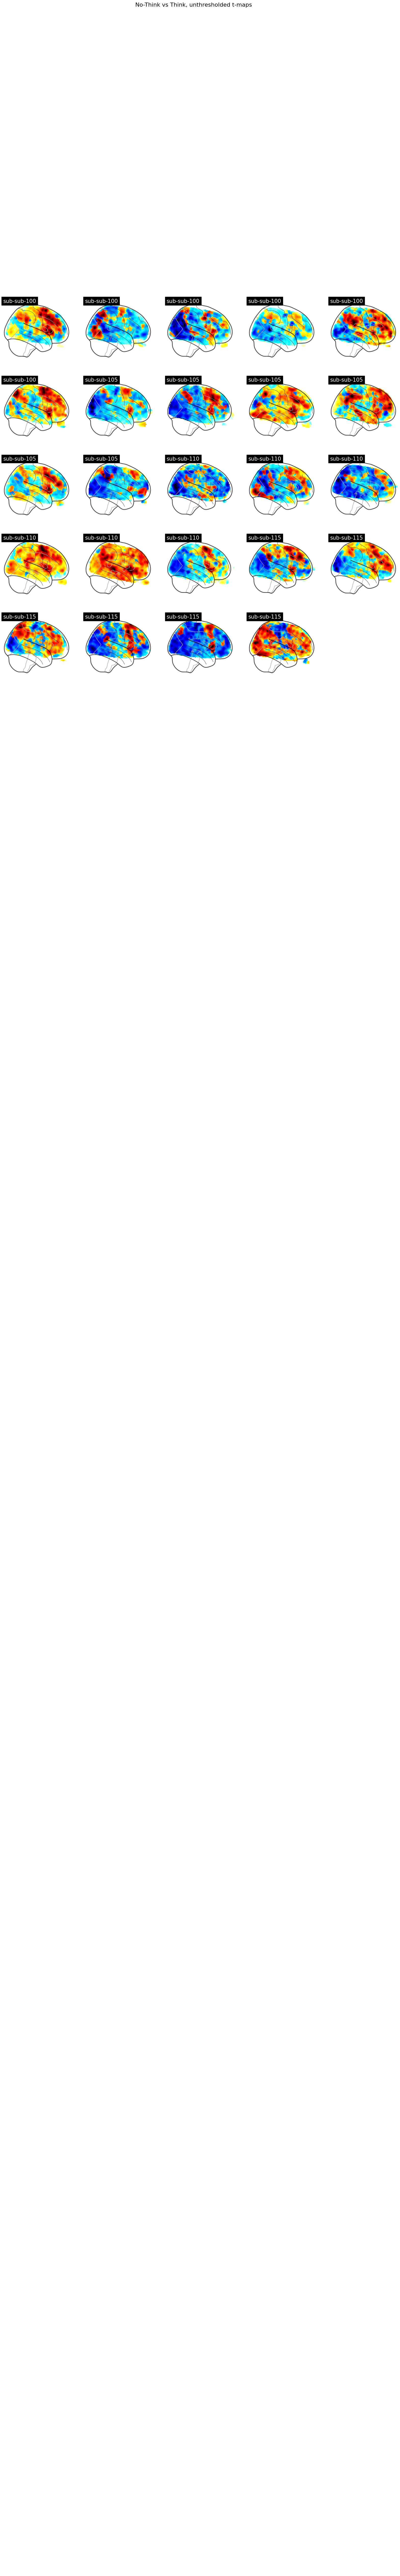

In [71]:
# get a list of all subjects
subjects = [op.basename(op.dirname(file)) for file in effect_files]

# Calculate number of subjects
n_subjects = len(subjects)

# Limit the number of columns to a maximum of n
cols = min(5, math.ceil(math.sqrt(n_subjects)))

# Calculate the required number of rows
rows = math.ceil(n_subjects / cols)

# Adjust the figure size (smaller scale factor, e.g., 3 inches per subplot)
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(4 * cols, 4 * rows))  # Adjust scaling factor

# Flatten axes to handle cases where there are fewer subjects than subplots
axes = axes.flatten()

# Plot each subject's stat_map
for i, stat_map in enumerate(ntt):
    plot_glass_brain(stat_map, 
                     title=f'sub-{subjects[i]}',
                     axes=axes[i],
                     plot_abs=False, 
                     display_mode='x')

# Hide any unused axes if the number of subjects is smaller than the number of axes
for ax in axes[len(ntt):]:
    ax.axis('off')

# Add a main title for the entire figure
fig.suptitle('No-Think vs Think, unthresholded t-maps', fontsize=16)

# Show the plot
plt.show()

## Specify the second-level model

In [53]:
# names = ['negNTi', 'neutrNTi', 'negNTni', 'neutrNTni', 'negT', 'neutrT'] 
conditions = ['con_0001.nii', 'con_0002.nii', 'con_0003.nii', 'con_0004.nii', 'con_0005.nii', 'con_0006.nii'] 

# Create an empty DataFrame
df = pd.DataFrame(columns=conditions + subjects)

# Populate the DataFrame with 0s and 1s
for i, condition in enumerate(conditions):
    # Filter files based on condition
    condition_files = [1 if condition in file else 0 for file in effect_files]
    # Add a column for the condition
    df[condition] = condition_files

# Populate the DataFrame with 0s and 1s for subjects
for i, subject in enumerate(subjects):
    # Filter files based on subject
    subject_files = [1 if f"{subject}" in file else 0 for file in effect_files]
    # Add a column for the subject
    df[subject] = subject_files

# Print the resulting DataFrame
design_matrix = df
design_matrix

,con_0001.nii,con_0002.nii,con_0003.nii,con_0004.nii,con_0005.nii,con_0006.nii,sub-100,sub-100,sub-100,sub-100,...,sub-205,sub-205,sub-205,sub-205,sub-215,sub-215,sub-215,sub-215,sub-215,sub-215
0,1,0,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
140,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
141,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1
142,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,1,1,1,1


Text(402.09722222222223, 0.5, 'stat maps')

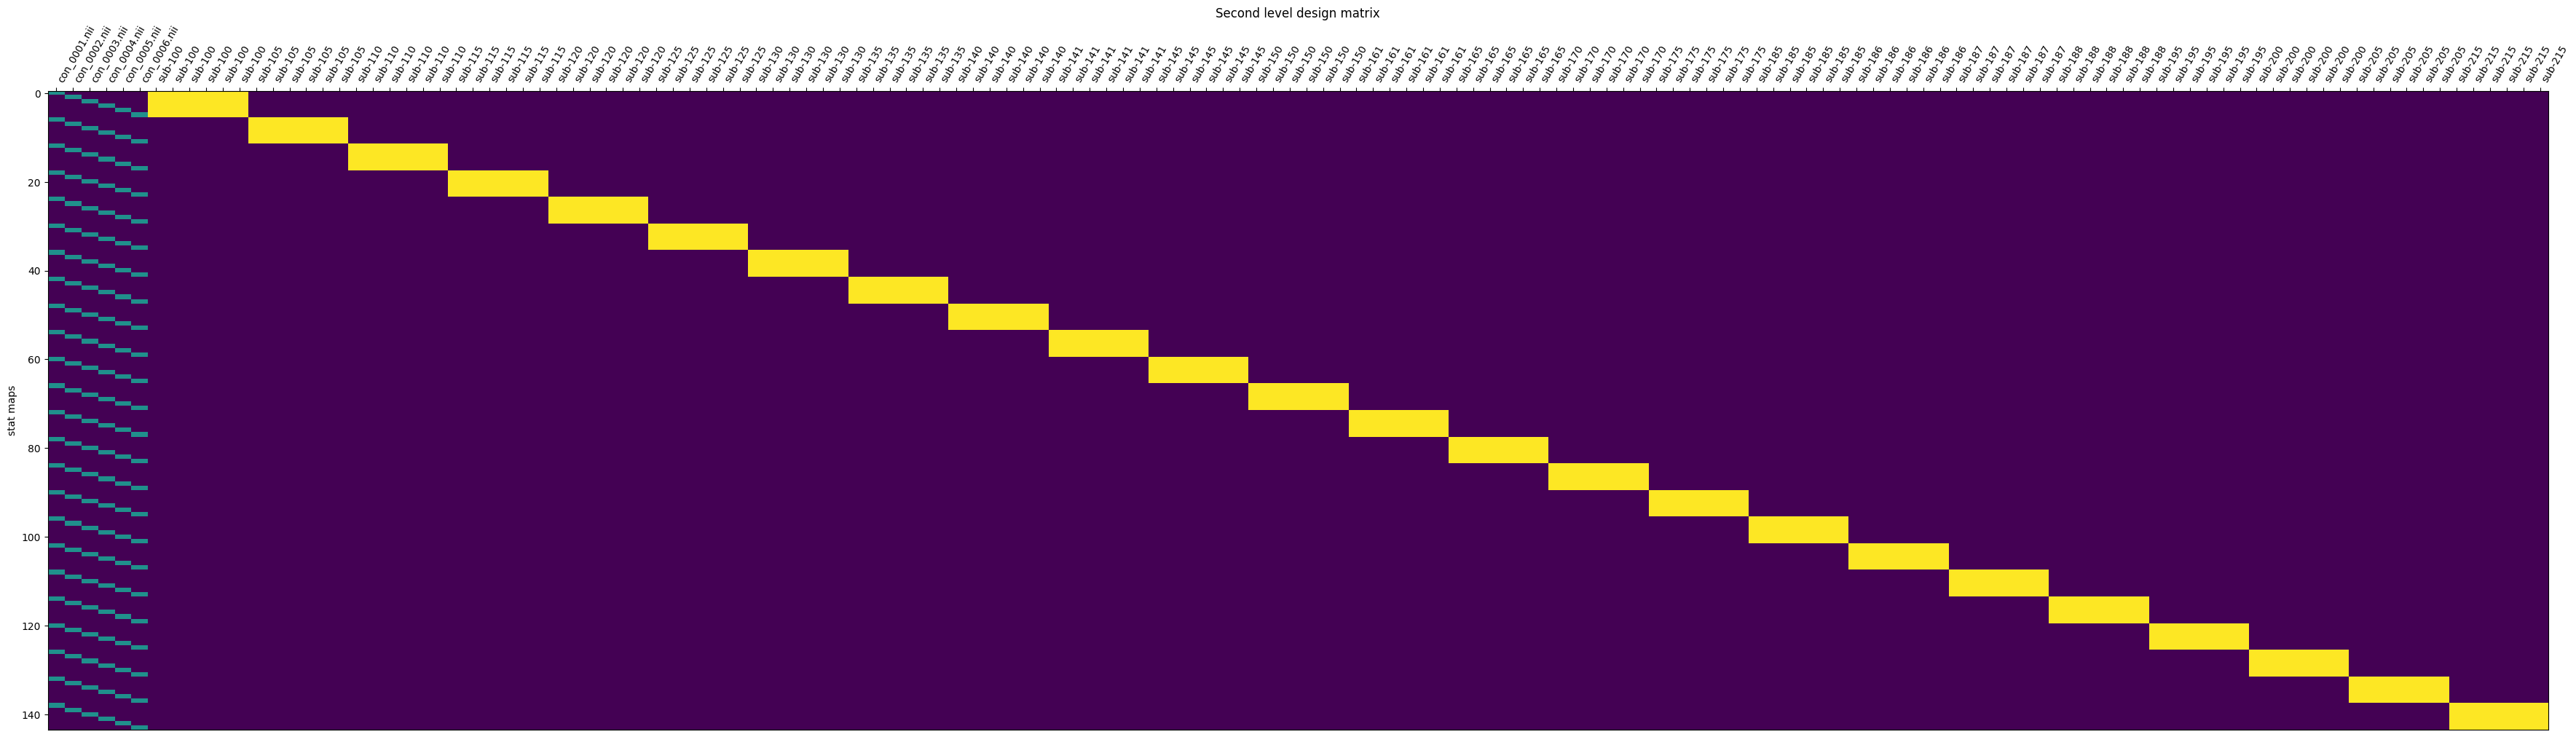

In [54]:
ax = plot_design_matrix(design_matrix)
ax.set_title("Second level design matrix", fontsize=12)
ax.set_ylabel("stat maps")

### Contrasts

In [55]:
# names = ['negNTi', 'neutrNTi', 'negNTni', 'neutrNTni', 'negT', 'neutrT'] 
# conditions = ['con_0001.nii', 'con_0002.nii', 'con_0003.nii', 'con_0004.nii', 'con_0005.nii', 'con_0006.nii'] 

n_columns = design_matrix.shape[1]

# Automatically compute the padding amount to avoid negative values
contrast_vectors = {
    'NoThink_Think': [1/4, 1/4, 1/4, 1/4, -1/2, -1/2]
}

# Dynamically pad the contrast vector
contrasts = {}
for name, vector in contrast_vectors.items():
    padding = max(0, n_columns - len(vector))  # Ensure non-negative padding
    contrasts[name] = np.pad(vector, (0, padding), 'constant')

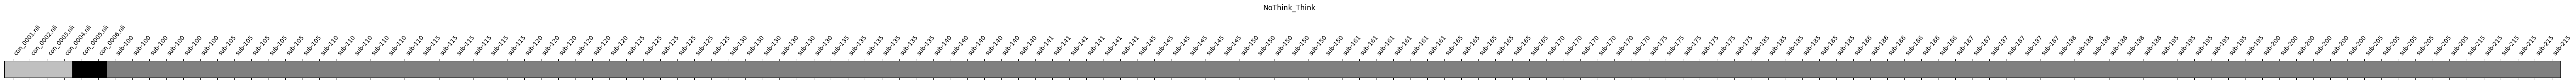

In [56]:
for contrast_id, contrast_val in contrasts.items():
    plot_contrast_matrix(contrast_val, design_matrix=design_matrix)
    plt.suptitle(contrast_id)

### FWE correction using non-parametric permutation testing

In [57]:
out_dict = non_parametric_inference(
    effect_files,
    design_matrix = design_matrix,
    second_level_contrast = contrasts['NoThink_Think'],
    n_perm = 10000, # ideally at least 10000
    two_sided_test = True,
    n_jobs = -1, # Use all available cores
    threshold = 0.001 # cluster level threshold; enables cluster-level inference
)

# Print the keys of the output dictionary
print(out_dict.keys())

/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/nilearn/mass_univariate/permuted_least_squares.py:986: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  image.new_img_like(masker.mask_img_, metric_map),
/imaging/correia/da05/conda/env/mri/lib/python3.11/site-packages/nilearn/masking.py:980: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  return new_img_like(mask_img, unmasked, affine)


dict_keys(['t', 'logp_max_t', 'size', 'logp_max_size', 'mass', 'logp_max_mass'])


In [58]:
alpha = 0.05
masked = out_dict['logp_max_t'].get_fdata() > -np.log10(alpha)
masked_t_map = out_dict['t'].get_fdata() * masked

# save the masked t-map as a nifti image
masked_t_map_img = nib.Nifti1Image(masked_t_map, out_dict['t'].affine)

In [59]:
# Save the unthresholded t-map

out_dir = op.join('/imaging/correia/da05/students/mohith/Gagnepain2017JoN/results/', 'group-level_permutation_on_spm_firstlevel', 'model_01', 'NoThinkThink')

if not op.exists(out_dir):
    os.makedirs(out_dir)
out_dict['t'].to_filename(op.join(out_dir, 'NoThink_Think_tmap.nii.gz'))

FWE (perm.) p<.05 threshold: 4.580


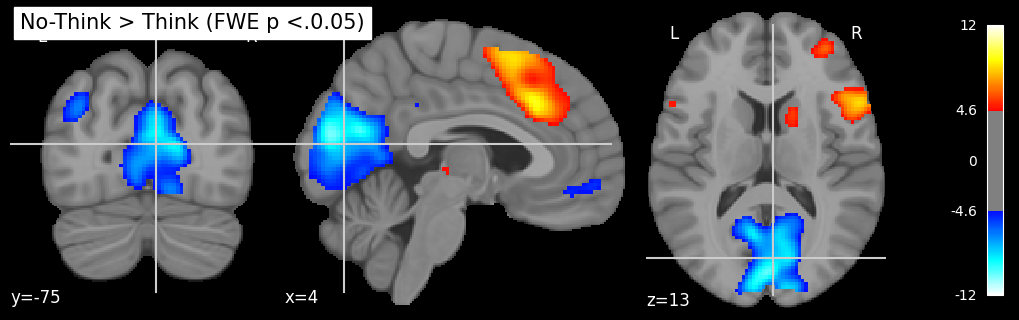

In [60]:
# Get the smallest t-value that is above the threshold (for the colorbar; the maps themselves are thresholded already)
threshold_fwe = masked_t_map[masked_t_map > 0].min()
print('FWE (perm.) p<.05 threshold: %.3f' % threshold_fwe)

plot_stat_map(
    masked_t_map_img, 
    threshold = threshold_fwe,       
    display_mode = 'ortho',
    black_bg = True,
    bg_img = mni152_template,
    title = f"No-Think > Think (FWE p <.{alpha})")

fig = plt.gcf()
fig.set_size_inches(10,3)
plt.show()

In [ ]:
# Interactive plotting
plot = view_img(
  masked_t_map_img, 
  bg_img=mni152_template, 
  threshold=threshold_fwe, 
  colorbar=True, 
  title = f"No-Think > Think (FWE p <.{alpha})"
  )

plot.open_in_browser()
# save the html file
plot.save_as_html(op.join(out_dir, 'NoThink_Think_tmap.html'))

## Summary results


In [62]:
# generate and save atlasreader output
create_output(
    masked_t_map_img, 
    cluster_extent = 20, 
    voxel_thresh = threshold_fwe,
    direction = 'pos',
    outdir = out_dir
)

In [63]:
# display the peak table
peaks = glob.glob(op.join(out_dir, '*_peaks.csv'))
display(pd.read_csv(peaks[0]))

,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,14.0,14.0,62.0,11.324800,19328.0,Supp_Motor_Area_R,Unknown,62.0% Right_Superior_Frontal_Gyrus
1,2.0,50.0,16.0,4.0,12.240282,17640.0,Frontal_Inf_Oper_R,Right-Cerebral-White-Matter,43.0% Right_Inferior_Frontal_Gyrus_pars_opercu...
2,3.0,38.0,36.0,36.0,7.598750,14824.0,Frontal_Mid_2_R,ctx-rh-rostralmiddlefrontal,40.0% Right_Frontal_Pole; 39.0% Right_Middle_F...
3,4.0,-44.0,16.0,4.0,8.016064,8024.0,Frontal_Inf_Tri_L,ctx-lh-parsopercularis,40.0% Left_Frontal_Operculum_Cortex; 23.0% Lef...
4,5.0,60.0,-44.0,32.0,9.999296,7120.0,SupraMarginal_R,ctx-rh-supramarginal,49.0% Right_Supramarginal_Gyrus_posterior_divi...
5,6.0,16.0,14.0,8.0,6.639268,1656.0,Caudate_R,Right-Caudate,76.0% Right_Caudate
6,7.0,-62.0,-52.0,32.0,6.162655,1512.0,no_label,ctx-lh-supramarginal,38.0% Left_Supramarginal_Gyrus_posterior_divis...
7,8.0,58.0,-24.0,-6.0,5.339821,392.0,Temporal_Mid_R,ctx-rh-middletemporal,57.0% Right_Middle_Temporal_Gyrus_posterior_di...
8,9.0,-28.0,50.0,20.0,5.233444,232.0,Frontal_Sup_2_L,ctx-lh-rostralmiddlefrontal,75.0% Left_Frontal_Pole
9,10.0,6.0,-20.0,-2.0,5.207186,176.0,Thalamus_R,Right-Thalamus-Proper,53.0% Right_Thalamus


In [64]:
# display the cluster table
clusters = glob.glob(op.join(out_dir, '*_clusters.csv'))
display(pd.read_csv(clusters[0]))

,cluster_id,peak_x,peak_y,peak_z,cluster_mean,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,14.0,14.0,62.0,6.365707,19328.0,24.01% Supp_Motor_Area_R; 19.12% Cingulate_Mid...,37.33% Unknown; 27.52% ctx-rh-superiorfrontal;...,30.13% Right_Superior_Frontal_Gyrus; 28.35% Ri...
1,2.0,50.0,16.0,4.0,7.216495,17640.0,28.93% Insula_R; 25.08% Frontal_Inf_Tri_R; 22....,35.42% Unknown; 22.18% Right-Cerebral-White-Ma...,22.04% Right_Inferior_Frontal_Gyrus_pars_operc...
2,3.0,38.0,36.0,36.0,5.615849,14824.0,65.79% Frontal_Mid_2_R; 16.35% Precentral_R; 1...,29.74% Unknown; 27.25% ctx-rh-rostralmiddlefro...,44.74% Right_Frontal_Pole; 39.45% Right_Middle...
3,4.0,-44.0,16.0,4.0,5.711313,8024.0,45.86% Insula_L; 27.62% Frontal_Inf_Tri_L; 13....,48.26% Unknown; 21.14% ctx-lh-parsopercularis;...,29.61% Left_Insular_Cortex; 24.63% Left_Fronta...
4,5.0,60.0,-44.0,32.0,6.741692,7120.0,56.63% SupraMarginal_R; 22.02% Parietal_Inf_R;...,32.36% Right-Cerebral-White-Matter; 31.01% ctx...,52.47% Right_Angular_Gyrus; 44.27% Right_Supra...
5,6.0,16.0,14.0,8.0,5.223188,1656.0,69.08% Caudate_R; 18.36% no_label; 6.28% Palli...,55.07% Right-Caudate; 33.33% Right-Cerebral-Wh...,77.29% Right_Caudate; 16.43% Right_Putamen; 6....
6,7.0,-62.0,-52.0,32.0,5.050816,1512.0,42.33% SupraMarginal_L; 30.69% Parietal_Inf_L;...,55.56% ctx-lh-supramarginal; 26.98% Left-Cereb...,78.31% Left_Supramarginal_Gyrus_posterior_divi...
7,8.0,58.0,-24.0,-6.0,4.882161,392.0,61.22% Temporal_Mid_R; 38.78% Temporal_Sup_R,67.35% Unknown; 32.65% ctx-rh-middletemporal,83.67% Right_Middle_Temporal_Gyrus_posterior_d...
8,9.0,-28.0,50.0,20.0,4.880607,232.0,55.17% Frontal_Sup_2_L; 44.83% Frontal_Mid_2_L,55.17% ctx-lh-rostralmiddlefrontal; 34.48% Lef...,100.00% Left_Frontal_Pole
9,10.0,6.0,-20.0,-2.0,4.835073,176.0,50.00% Thalamus_R; 50.00% no_label,72.73% Right-Thalamus-Proper; 22.73% Right-Ven...,90.91% Right_Thalamus; 9.09% no_label
